In [2]:
from IPython.display import display, SVG
import numpy as np
import os
import pydot
import sys

import pydrake
from pydrake.all import (
    Adder, AddMultibodyPlantSceneGraph, Demultiplexer, DiagramBuilder, 
    InverseDynamicsController, MakeMultibodyStateToWsgStateSystem, 
    MeshcatVisualizerCpp, MultibodyPlant,Parser, PassThrough, 
    SchunkWsgPositionController, StateInterpolatorWithDiscreteDerivative,
    RigidTransform, RotationMatrix, Simulator, SpatialVelocity, ConstantVectorSource
)
from manipulation.meshcat_cpp_utils import StartMeshcat
from manipulation.scenarios import AddIiwa, AddWsg, AddRgbdSensors
from manipulation.utils import FindResource
from manipulation import running_as_notebook
from manipulation.scenarios import AddShape

if running_as_notebook and sys.platform == "linux" and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

## Shamelessly Copying from Russ's Piazza

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

Meshcat is now available at https://94a9bd61-ed58-4c78-95db-bc94494e48ba.deepnoteproject.com


In [ ]:
def MakeManipulationStation(time_step=0.002):
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, cameras, ball, and ground to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa)
    Parser(plant).AddModelFromFile(FindResource("models/camera_box.sdf"), "camera0")
    Parser(plant).AddModelFromFile('ball.urdf', "ball")
    ground = AddShape(plant, pydrake.geometry.Box(10,10,2.0), name="ground", mu=0.2)
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("ground"), RigidTransform(p=[0,0,-1.0]))
    
    plant.Finalize()


    num_iiwa_positions = plant.num_positions(iiwa)

    # I need a PassThrough system so that I can export the input port.
    iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
    builder.ExportInput(iiwa_position.get_input_port(), "iiwa_position")
    builder.ExportOutput(iiwa_position.get_output_port(), "iiwa_position_command")

    # Export the iiwa "state" outputs.
    demux = builder.AddSystem(Demultiplexer(2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(), adder.get_input_port(0))

    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(), adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(), plant.get_actuation_input_port(iiwa))

    # Add discrete derivative to command velocities.
    desired_state_from_position = builder.AddSystem(
        StateInterpolatorWithDiscreteDerivative(num_iiwa_positions, time_step, suppress_initial_transient=True))
    desired_state_from_position.set_name("desired_state_from_position")
    builder.Connect(desired_state_from_position.get_output_port(), iiwa_controller.get_input_port_desired_state())
    builder.Connect(iiwa_position.get_output_port(), desired_state_from_position.get_input_port())

    # Export commanded torques.
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

    # Wsg controller.
    wsg_controller = builder.AddSystem(SchunkWsgPositionController())
    wsg_controller.set_name("wsg_controller")
    builder.Connect(wsg_controller.get_generalized_force_output_port(), plant.get_actuation_input_port(wsg))
    builder.Connect(plant.get_state_output_port(wsg), wsg_controller.get_state_input_port())
    builder.ExportInput(wsg_controller.get_desired_position_input_port(), "wsg_position")
    builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
    wsg_mbp_state_to_wsg_state = builder.AddSystem(MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg), wsg_mbp_state_to_wsg_state.get_input_port())
    builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(), "wsg_state_measured")
    builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

    # Cameras.
    AddRgbdSensors(builder, plant, scene_graph)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(), "contact_results")
    builder.ExportOutput(plant.get_state_output_port(), "plant_continuous_state")

    diagram = builder.Build()
    return diagram, plant

diagram, plant = MakeManipulationStation()

builder = DiagramBuilder()
station = builder.AddSystem(diagram)

ball = plant.GetBodyByName("ball")

MeshcatVisualizerCpp.AddToBuilder(
    builder, station.GetOutputPort("geometry_query"), meshcat)

#fix wsg position
wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
builder.Connect(wsg_position.get_output_port(), station.GetInputPort("wsg_position"))

#export iiwa position
builder.ExportInput(station.GetInputPort("iiwa_position"))

diagram = builder.Build()
context = diagram.CreateDefaultContext()
diagram.Publish(context)

pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].write_png('diagram.png')
#display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

In [ ]:
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
plant_context = plant.GetMyContextFromRoot(context)

#initial condition
X_W_ball_initial = RigidTransform(RotationMatrix.MakeXRotation(0), [1, 1, 1])
V_W_ball_initial = SpatialVelocity([0,0,0,0,0,10]) # of the form w_x, w_y, w_z, v_x, v_y, v_z

plant.SetFreeBodyPose(plant_context, ball, X_W_ball_initial)
plant.SetFreeBodySpatialVelocity(body=ball, context=plant_context,  V_WB=V_W_ball_initial)

simulator.set_target_realtime_rate(0.25)
simulator.AdvanceTo(0.01)

In [ ]:
simulator.AdvanceTo(3)

KernelInterrupted: Execution interrupted by the Jupyter kernel.

## trajectory optimization via direct collocation: (everything below here is testing)

In [18]:
from pydrake.all import (DiagramBuilder, DirectCollocation, MultibodyPlant,
                         MultibodyPositionToGeometryPose, Parser,
                         PiecewisePolynomial, PlanarSceneGraphVisualizer,
                         SceneGraph, Simulator, Solve, TrajectorySource,
                         AddMultibodyPlantSceneGraph, PassThrough, BasicVector)

plant = MultibodyPlant(time_step = 0)
iiwa = AddIiwa(plant)
#wsg = AddWsg(plant, iiwa)
plant.Finalize()

#display(SVG(pydot.graph_from_dot_data(plant.GetGraphvizString())[0].create_svg()))

context = plant.CreateDefaultContext()

dircol = DirectCollocation(
    plant,
    context,
    num_time_samples=21,
    minimum_timestep=0.1,
    maximum_timestep=1,
    input_port_index = plant.get_input_port(3).get_index())

dircol.AddEqualTimeIntervalsConstraints()

# set initial state
initial_state = tuple([0]*14) # i have no idea what the ordering here is chief
dircol.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())

# set final state
final_state_lb = tuple([0.95]*14)
final_state_ub = tuple([1.05]*14)
dircol.AddBoundingBoxConstraint(final_state_lb, final_state_ub, dircol.final_state())

# constrain joint torques
#foo = dircol.decision_variables()[294:440]
#for f in foo:
#    dircol.AddBoundingBoxConstraint(-10, 10, f)

# add cost
u = dircol.input()
x = dircol.state()

dircol.AddFinalCost(dircol.time()**2)
#dircol.AddRunningCost((10 * u.dot(u)))

# set initial state 
#initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
#dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
print("Success? ", result.is_success())
print('optimal cost = ', result.get_optimal_cost())
print('solver is: ', result.get_solver_id().name())

if(not result.is_success()):
    print(dircol)
    infeasible_constraints = result.GetInfeasibleConstraints(dircol)
    for c in infeasible_constraints:
        print(f"infeasible constraint: {c}")

assert result.is_success()

Success?  True
optimal cost =  4.000000000000051
solver is:  SNOPT/fortran


In [ ]:
x_trajectory = dircol.ReconstructStateTrajectory(result)

plant = MultibodyPlant(time_step = 0)
scene_graph = SceneGraph()
plant.RegisterAsSourceForSceneGraph(scene_graph)
iiwa = AddIiwa(plant)
#wsg = AddWsg(plant, iiwa)
plant.Finalize()

builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))

visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph.get_query_output_port(), meshcat)

diagram = builder.Build()
#display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())) # display diagram

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(0.25)
simulator.AdvanceTo(0.1)

NameError: name 'meshcat' is not defined

In [ ]:
simulator.set_target_realtime_rate(0.25)
simulator.AdvanceTo(21)

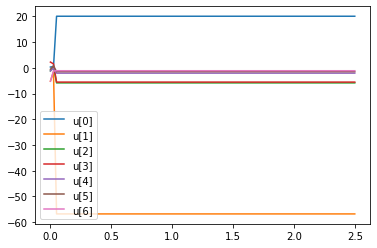

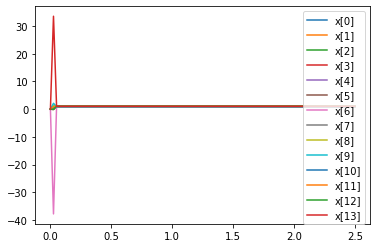

In [22]:
x_trajectory = dircol.ReconstructStateTrajectory(result)
u_trajectory = dircol.ReconstructInputTrajectory(result)

ts = np.linspace(0, 2.5, 100)
xs = np.zeros((100, 14))
us = np.zeros((100, 7))

for t in range(len(ts)):
    xs[t,:] = x_trajectory.value(t).T
    us[t,:] = u_trajectory.value(t).T

import matplotlib.pyplot as plt
for i in range(7):
    plt.plot(ts, us[:,i], label=f'u[{i}]')
plt.legend()
plt.show()

for i in range(14):
    plt.plot(ts, xs[:,i], label=f'x[{i}]')
plt.legend()
plt.show()

    

## predict ball position/velocity from initial state

In [16]:
def predict_ball_trajectory(p_i,v_i,t):
    g = -9.81
    px_i, py_i, pz_i = p_i.translation()
    vx_i, vy_i, vz_i = v_i.translational()
    
    px_t = px_i + (vx_i*t)
    py_t = py_i + (vy_i*t)
    pz_t = pz_i + (vz_i*t) + (0.5*g*t**2)

    vx_t = vx_i
    vy_t = vy_i
    vz_t = vz_i + t*g

    p_t = RigidTransform(RotationMatrix.MakeXRotation(0), [px_t, py_t, pz_t])
    v_t = SpatialVelocity([0,0,0,vx_t, vy_t, vz_t])
    
    return p_t, v_t

def predict_ball_trajectory_test():
    # quick test to make sure the trajectories are ballistic

    X_W_ball_initial = RigidTransform(RotationMatrix.MakeXRotation(0), [1, 1, 1])
    V_W_ball_initial = SpatialVelocity([0,0,0,0,0,10]) # of the form w_x, w_y, w_z, v_x, v_y, v_z
    
    time_step = 0.1
    run_time = 5
    steps = int(run_time/time_step)
    time = np.linspace(0, run_time, steps)
    positions = np.zeros((3, steps))
    velocities = np.zeros((3, steps))

    for i in range(steps):
        p, v = predict_ball_trajectory(X_W_ball_initial, V_W_ball_initial, time[i])
        positions[:,i] = p.translation()
        velocities[:,i] = v.translational()

    import matplotlib.pyplot as plt
    plt.plot(time, velocities[0])
    plt.plot(time, velocities[1])
    plt.plot(time, velocities[2])
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=94a9bd61-ed58-4c78-95db-bc94494e48ba' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>